### Modern Portfolio Theory
This will be a short package on markowitz optimization and methods of finding various market portfolios

In [4]:
from sqlalchemy import Table, MetaData, Column, select, create_engine, inspect
from sqlalchemy.orm import sessionmaker, declarative_base
import pandas as pd
import numpy as np

## access data

def Get_data(ticker):
    engine = create_engine(f'sqlite:///Data.db')
    metadata = MetaData()
    metadata.reflect(bind=engine)

    # Set up the session
    Session = sessionmaker(bind=engine)
    session = Session()

    
    # Check if the table exists in the database
    if ticker in metadata.tables:
        # Dynamically get the table using the table name
        table = Table(ticker, metadata, autoload_with=engine)

        # Create a query to select all data from the table
        query = select(table).limit(10000)

        # Execute the query and fetch results
        result = session.execute(query)

        # Iterate through the result and print each row
        X = pd.DataFrame(result)

    else:
        return print(f"Table '{table_name}' not found in the database.")
    return X

def create_portfolio(tickers):
    portfolio = {}
    for i in tickers:
        portfolio[i] = Get_data(i)
    return portfolio

def populate_available_tickers():
    engine = create_engine(f'sqlite:///Data.db')
    inspector = inspect(engine)
    table_names = inspector.get_table_names()
    return table_names


In [2]:
all_tickers = populate_available_tickers()
portfolio_1 = create_portfolio(all_tickers[0:30:1])

for i in portfolio_1.keys():
    if portfolio_1[i].empty:
        portfolio_1.pop(i)

RuntimeError: dictionary changed size during iteration

### Populating stock returns and getting returns and variance matrices
Now we will be getting vectors `r` and `S` that contain the returns for each financial instrument in our portfolio

In [5]:
def returns_matrix(portfolio):
    returns_dict = {}
    for i in portfolio.keys():
        returns_dict[i] = portfolio[i]['adj_close'].pct_change()
    returns_matrix = pd.DataFrame(returns_dict)
    return returns_matrix
            
def create_covariance_matrix(returns_matrix):
    cov_matrix = returns_matrix.cov()
    return cov_matrix

### Global Minimum Variance Portfolio
The `GMVP` or other the global minimum variance portfolio finds the weights of individual components in a portfolio to generate one of lowest variance.

This follows the principle of finding the matrix minima via the following formula

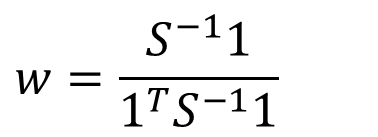

Where we will get the minimal variance weight vector `w` each unit of financial instrument

In [6]:
def Get_GMVP_weights(S):
    ones = np.ones(len(S))
    ones_Sinv = np.matmul(np.linalg.inv(S),ones)
    weights = ones_Sinv / np.matmul(ones.T,ones_Sinv)
    n = 0
    weights_series = {}
    for i in S.keys():
        weights_series[i] = weights[n]
        n +=1
    weights = pd.Series(weights_series)
    return weights

print(Get_GMVP_weights(create_covariance_matrix(returns_matrix(portfolio_1).dropna())))

AAPL     0.074402
ABBV     0.154139
ABT      0.105886
ACN      0.008833
ADBE    -0.041154
AMGN     0.010413
AMZN     0.013397
AVGO    -0.007050
AXP      0.025823
BABA    -0.000673
BAC     -0.073846
BKNG     0.042346
BLK      0.012785
BMY      0.028840
CAT     -0.053749
CMCSA    0.020723
COST     0.131029
CRM      0.005053
CSCO     0.065285
CVS      0.020068
CVX      0.117858
DE       0.042110
DHR      0.027312
DIS      0.019630
GILD     0.067528
GOOG     0.128161
GOOGL    0.013249
GS       0.043233
HD      -0.001630
dtype: float64


### Visualising weights and Covariance matrix with Heat

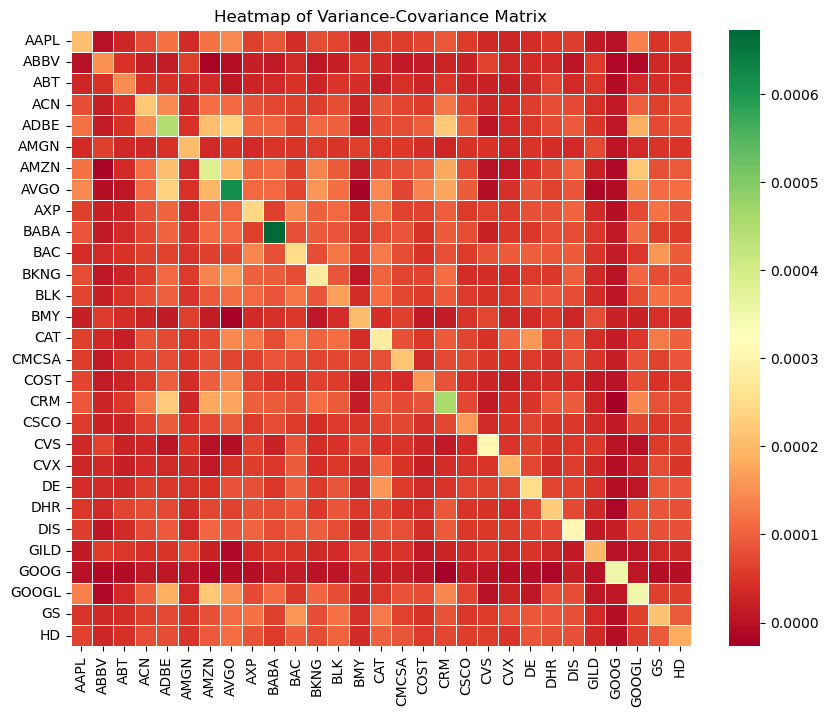

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(create_covariance_matrix(returns_matrix(portfolio_1).dropna()), cmap='RdYlGn', linewidths=0.5)
plt.title('Heatmap of Variance-Covariance Matrix')
plt.show()

### Tangency Portfolio
With our markowitz optimised formulas, we can now extend our formulas for the Tangency portfolio with accordance to the following formula

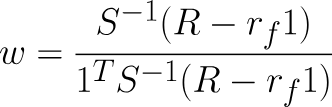

The tangency portfolio formula will return the weights as intended

In [8]:
def Get_tangency_weights(r,S,rfr=0.0001):
    mu_r = r.mean()
    Sinv_rmu = np.matmul(np.linalg.inv(S),(mu_r-rfr))
    weights = Sinv_rmu / sum(Sinv_rmu)
    k = 0
    m ={}
    for i in weights:
        m[r.columns[k]] = i
        k +=1
    m = pd.Series(m)
    return m

0.005147274807199596


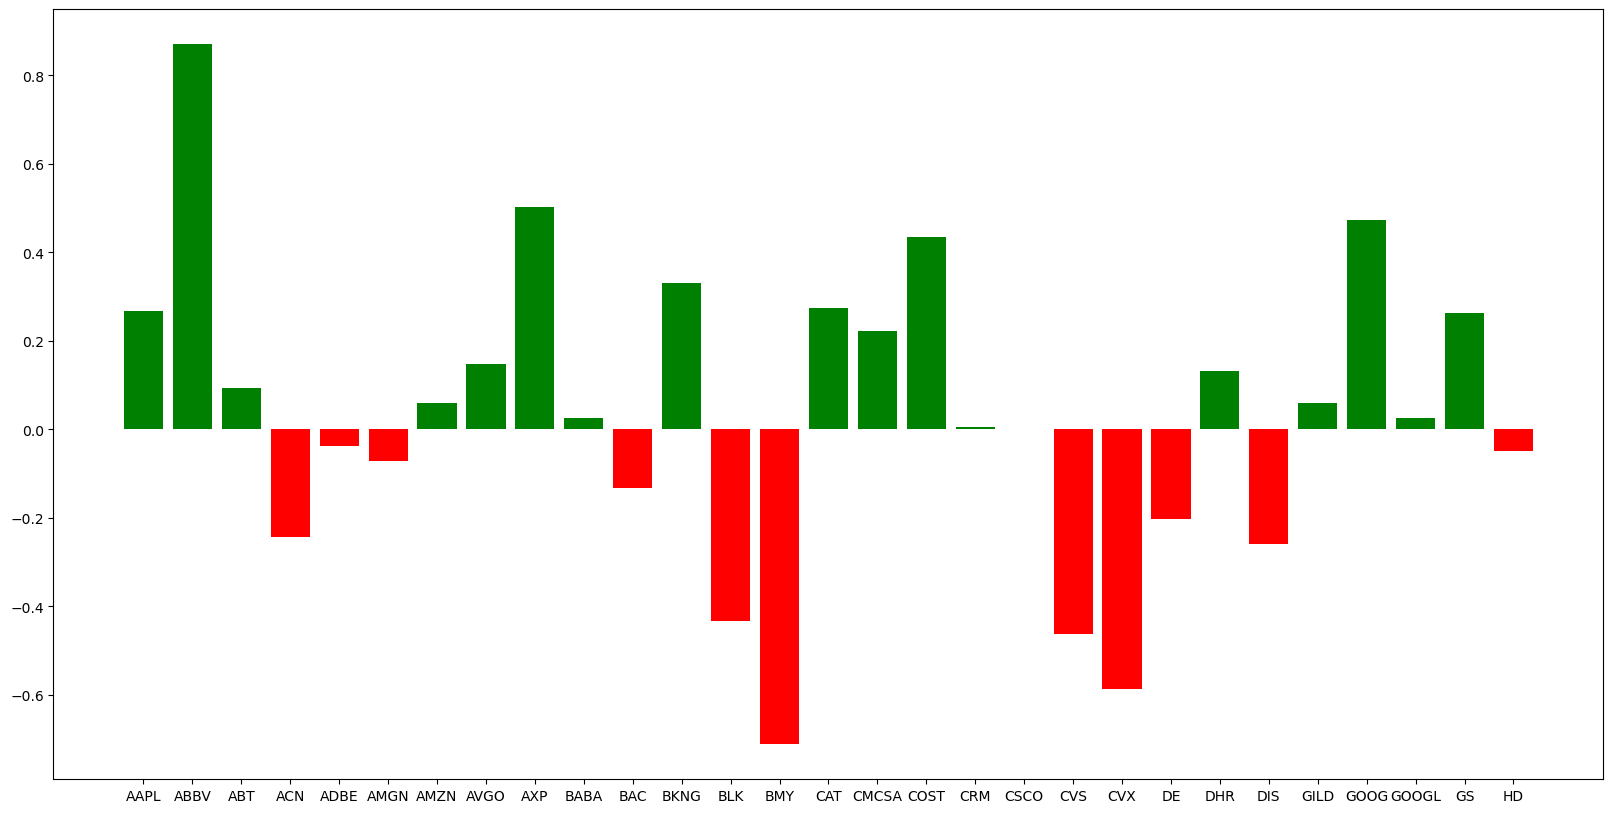

In [145]:
values = Get_tangency_weights(returns_matrix(portfolio_1).dropna(),create_covariance_matrix(returns_matrix(portfolio_1).dropna()),rfr=0.00011)
print(np.dot(values,returns_matrix(portfolio_1).dropna().mean()))
colors = ['green' if value >= 0 else 'red' for value in values.values]

plt.figure(figsize=(20, 10))
plt.bar(values.keys(),values.values,color=colors)
plt.show()

### Measuring the profile of the portfolios return to risk


In [ ]:
cleaned_returns = returns_matrix(portfolio_1).dropna()
mean_returns = cleaned_returns.mean()
cov_matrix = cleaned_returns.cov()

num_portfolios = 1000000
results = np.zeros((3, num_portfolios))
num_assets = len(mean_returns)

for i in range(num_portfolios):
    np.random.seed(i)
    weights = np.random.uniform(-1, 1, num_assets)
    weights /= np.sum(weights)
    
    portfolio_return = np.sum(weights * mean_returns)
    portfolio_stddev = np.sqrt(np.matmul(weights.T, np.matmul(cov_matrix, weights)))
    sharpe_ratio = portfolio_return / portfolio_stddev
    
    results[0, i] = portfolio_return
    results[1, i] = portfolio_stddev
    results[2, i] = sharpe_ratio

mean_returns = returns_matrix(portfolio_1).dropna().mean()
cov_matrix = create_covariance_matrix(returns_matrix(portfolio_1).dropna())

optimal = Get_tangency_weights(returns_matrix(portfolio_1).dropna(), cov_matrix, rfr=0.0001)

tangency_return = np.matmul(optimal.T, mean_returns)
tangency_risk = (np.matmul(optimal.T, np.matmul(cov_matrix, optimal))) ** 0.5

opt_r = []
opt_s = []

for m in range(0, 30000, 1):
    i = m / 10000
    r = 0.0001 + i * (tangency_return - 0.0001)
    sigma = i * tangency_risk

    opt_r.append(r)
    opt_s.append(sigma)
     

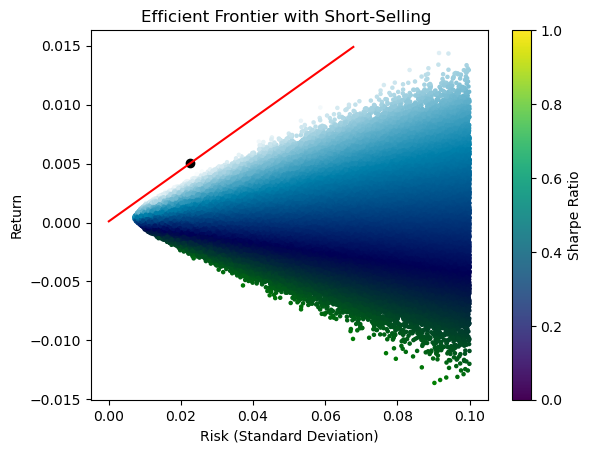

In [151]:
risk_threshold = 0.1
return_min_threshold = -0.02
return_max_threshold = 0.02

filtered_indices = (results[1, :] < risk_threshold) & (results[0, :] > return_min_threshold) & (results[0, :] < return_max_threshold)
filtered_risks = results[1, filtered_indices]
filtered_returns = results[0, filtered_indices]
filtered_sharpe = results[2, filtered_indices]

plt.scatter(filtered_risks, filtered_returns, c=filtered_sharpe, cmap='ocean', s=5)
plt.scatter([np.matmul(optimal.T,np.matmul(cov_matrix, optimal))**0.5], [np.dot(optimal,returns_matrix(portfolio_1).dropna().mean())],color="black")
plt.colorbar(label='Sharpe Ratio')
plt.plot(opt_s, opt_r, color="red")
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return')
plt.title('Efficient Frontier with Short-Selling ')

plt.show()

### Optimal portfolios with different utility functions
lets first find max utility given the `risk-neutral utility function`

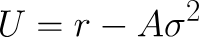

To find the optimal weights of `Risk free rate`, `Equity weights` we will have to find the tangency portfolio first.

Then working backwards, we can find the portfolio returns and portfolio variance accordingly

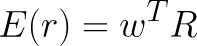

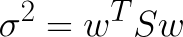




In [155]:
import numpy as np
from scipy.optimize import minimize

def Expon_risk_utility(r,sigma,A=0.5309):
    return r - 0.5*A * np.exp(sigma)
     
def risk_neutral_utility(r, sigma,A=14):
    return r - 0.5*A * sigma ** 2 

def Get_optimal_weights(r, S, rfr=0.0001):
    w = Get_tangency_weights(r, S, rfr=rfr)
    mu_r = r.mean()
    portfolio_returns = np.matmul(w.T, mu_r)
    portfolio_variance = np.matmul(w.T, np.matmul(S, w))
    def objective(optim_w):
        combined_return = optim_w[1] * portfolio_returns + (1 - optim_w[1]) * rfr
        combined_variance = (optim_w[1]**2) * portfolio_variance
        
        return -risk_neutral_utility(combined_return, combined_variance**0.5)
    
    initial_guess = [0, 1]

    constraints = ({
        'type': 'eq',
        'fun': lambda optim_w: np.sum(optim_w) - 1
    })
    
    bounds = [(-10, 10), (-10, 10)]
    
    result = minimize(objective, initial_guess, bounds=bounds, constraints=constraints)
    expec_r = result.x[1]*portfolio_returns +  result.x[0]*rfr
    sd =((result.x[1]**2)*portfolio_variance)**0.5
    
    optimal_weights_series = pd.Series({
        'RFR': result.x[0],
        'Tangency Portfolio': result.x[1],
        'E(r)': expec_r,
        'Risk': sd,
        "Sharpe" : expec_r/sd,
        "Utility": risk_neutral_utility(expec_r, sd)
    })
    
    return optimal_weights_series
x = Get_optimal_weights(returns_matrix(portfolio_1).dropna(),create_covariance_matrix(returns_matrix(portfolio_1).dropna()),rfr=0.0001)
print(Get_optimal_weights(returns_matrix(portfolio_1).dropna(),create_covariance_matrix(returns_matrix(portfolio_1).dropna()),rfr=0.0001))

RFR                   0.309851
Tangency Portfolio    0.690149
E(r)                  0.003504
Risk                  0.015594
Sharpe                0.224725
Utility               0.001802
dtype: float64


#### Plotting utility functionn against the cml and efficient frontier

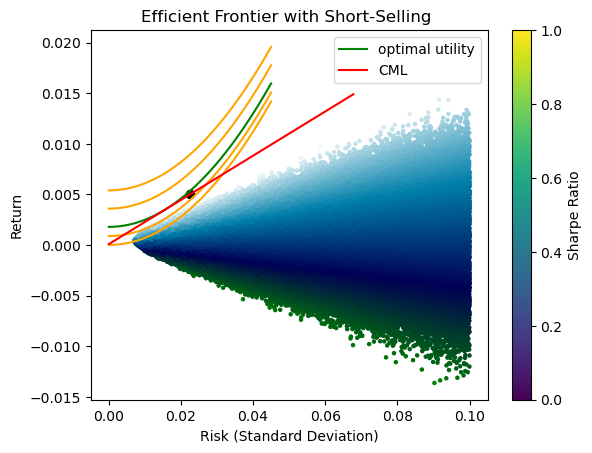

In [169]:
risk_threshold = 0.1
return_min_threshold = -0.02
return_max_threshold = 0.02

utility = x["Utility"]

possibilities = [utility * 3,utility * 2,utility, utility/2,utility/100]

for y in possibilities:
    u_r =[]
    u_s =[]
    for sins in range(4500):
        sma = sins / 100000
        ret = y + 7 * (sma **2)
        u_r.append(ret)
        u_s.append(sma)
    if y == utility:
        plt.plot(u_s,u_r,color = "green",label="optimal utility")
    else:
        plt.plot(u_s,u_r,color = "orange")

filtered_indices = (results[1, :] < risk_threshold) & (results[0, :] > return_min_threshold) & (results[0, :] < return_max_threshold)
filtered_risks = results[1, filtered_indices]
filtered_returns = results[0, filtered_indices]
filtered_sharpe = results[2, filtered_indices]

plt.scatter(filtered_risks, filtered_returns, c=filtered_sharpe, cmap='ocean', s=5)
plt.scatter([np.matmul(optimal.T,np.matmul(cov_matrix, optimal))**0.5], [np.dot(optimal,returns_matrix(portfolio_1).dropna().mean())],color="black")
plt.colorbar(label='Sharpe Ratio')
plt.plot(opt_s, opt_r, color="red",label="CML")
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return')
plt.title('Efficient Frontier with Short-Selling ')

plt.legend()
plt.show()